# Parte I prueba técnica

#### *David Alcántara*

# Introducción

### Contexto

El fraude es una amenaza constante en todas las escalas comerciales. Detectarlo requiere tecnología avanzada y análisis profundo de datos para identificar patrones anómalos y salvaguardar activos. Desde el robo de identidad hasta el fraude financiero, las organizaciones deben estar vigilantes. La detección implica una combinación de tecnología, experiencia y diligencia para mantener a raya a los estafadores y proteger la integridad de la empresa. Es un proceso continuo y dinámico en la lucha contra la actividad delictiva.

El auditor Senior con el que trabajas te menciona actividades que son consideradas sospechosas:
1.	Transacciones de montos altos durante las primeras horas de la mañana, es decir, entre las 6:00 a 8:00 a. m.
2.	Algunos estafadores efectúan múltiples transacciones de bajo valor (generalmente menos de $2,00) utilizando tarjetas de crédito, lo cual suele pasar desapercibido para los titulares de estas.


### Objetivo

**Identificar actividades fraudulentas por medio del análisis de datos.** 

### Librerías y Funciones

A continuación se presetan todas las librerías y seteos iniciales que son necesarios para los procesos que se usarán a lo largo del documento.

In [9]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display_html, display, HTML
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import os
import warnings

import os
os. getcwd() 

# Settings
## Removing Scientific Notation
pd.options.display.float_format = '{:.2f}'.format
## Removing Warnings
warnings.filterwarnings('ignore')
## Display
pd.options.display.max_colwidth = 10000
plt.rcParams['figure.figsize'] = [24, 14]
## Global Variables
DESKTOP_PATH: str = os.getcwd()
DATA_PATH: str = 'Data_Prueba/Parte_I'
GLOBAL_PATH: str = f'{DESKTOP_PATH}/{DATA_PATH}'
RANDOM_VALUE: int = 1234
MAIN_COLUMNS: list = ['id','date', 'amount', 'card']

In [2]:
%%html
<style> 
   table td, table th, table tr {text-align:center !important;}
</style>

In [123]:
def display_side_by_side(
   dfs: list, 
   captions: list
) -> None :
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style. \
            set_table_attributes("style='display:inline'"). \
            set_caption(caption). \
            _repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

def get_total_na(df: pd.DataFrame) -> list:
   return [column for column in df.columns if len(df[df[column].isna()]) > 0 or len(df[df[column].isnull()]) > 0]

def get_kmeans_clusters(
   df: pd.DataFrame,
   num_clusters: int,
   with_hour: bool
) -> pd.DataFrame :
   if with_hour :
      X_scaled = scale(df[['amount', 'hour'] ])
   else :
      X_scaled = scale(df[['amount']]).reshape(-1, 1)
   y_predict = KMeans(n_clusters = num_clusters, random_state = RANDOM_VALUE).fit(X_scaled)
   return df.assign(cluster = y_predict.labels_).reset_index(drop=True)

def get_bar_plot_count(
   df: pd.DataFrame, 
   variable: str
) -> None :
   df_count = df[variable].value_counts().sort_index().reset_index()
   plt.bar(df_count['index'], df_count[variable])
   if len(df_count) > 10:
      plt.xticks(rotation = 90)
      
def get_cluster_info(
   df: pd.DataFrame,
   num_cluster: int
) -> pd.DataFrame:
   df_info = pd.DataFrame()
   for cluster in range(num_cluster):
      df_cluster_filtered = df[df['cluster'] == cluster].reset_index(drop=True)
      df_cluster_info = pd.DataFrame(df_cluster_filtered['amount'].describe()).rename(columns={'amount': f'cluster_{cluster}'})
      df_info = pd.concat([df_info,df_cluster_info], axis=1)
   return df_info

def get_group_count(
   df: pd.DataFrame,
   column: str,
   max_amount_transaction: int,
   min_count_transaction: int
) -> pd.DataFrame:
   df_merge_low = df[df['amount'] <= max_amount_transaction]
   df_group = (
      df_merge_low.groupby([column], as_index=True)[['amount']].count().
      rename(columns={'amount': 'count'}).reset_index()
   )
   count_dates = df_group[df_group['count'] >= min_count_transaction][column]
   return (
      df_merge_low[df_merge_low[column].isin(count_dates)].
      sort_values(['date'])
      [MAIN_COLUMNS].
      reset_index(drop=True)
   )

### Importación y definición de Datos

La siguiente tabla muestra los datos que serán utilizads a lo largo de este breve informe.

Como podemos observar, existe una tabla central que es la ecumula la información histórica de las transacciones, mientras que otras dos guardan información específica sobre productos y tarjetas, siendo las últimas dos tablas sólo contenedores del detalle de id de las categorías anteriores.

In [75]:
df_transaction = pd.read_csv(f'{GLOBAL_PATH}/transaction.csv', sep=',', header=0)
df_merchant = pd.read_csv(f'{GLOBAL_PATH}/merchant.csv', sep=',', header=0)
df_merchant_category = pd.read_csv(f'{GLOBAL_PATH}/merchant_category.csv', sep=',', header=0)
df_credit_card = pd.read_csv(f'{GLOBAL_PATH}/credit_card.csv', sep=',', header=0)
df_card_holder = pd.read_csv(f'{GLOBAL_PATH}/card_holder.csv', sep=',', header=0)

display_side_by_side(
   [df_transaction.head(), df_merchant.head(), df_merchant_category.head(), df_credit_card.head(), df_card_holder.head()],
   ['<h2>Transactions</h2>', '<h2>Merchant</h2>', '<h2>Merchant Category</h2>', '<h2>Credit Card</h2>', '<h2>Card Holder</h2>']
)

Como suele suceder, los datos rerquieren de un proceso inicial de definición y transformación. A continuación se muestran las dos tablas que requerían de traer información desde otras tablas para explicitar su contenido.

In [5]:
df_merchant_join = df_merchant.merge(
   df_merchant_category.rename(columns={'id': 'id_merchant_category', 'name': 'merchant_category'}),
   on = ['id_merchant_category'], 
   how = 'left'
).drop(columns=['id_merchant_category'])

df_credit_card_join = df_credit_card.assign(
   card = lambda df: df['card'].astype('int64')
).merge(
   df_card_holder.rename(columns={'id': 'id_card_holder'}),
   on = ['id_card_holder'], 
   how = 'left'
).drop(columns=['id_card_holder'])

display_side_by_side(
   [df_merchant_join.head(), df_credit_card_join.head()],
   ['<h2>Merchant Join</h2>', '<h2>Credit Card Join</h2>']
)

Finalmente, la siguiente tabla muestra la tabla histórica central junto a la información asociada al tipo de negocio de las transacciones.

In [60]:
df_merge = df_transaction.assign(
   date = lambda df: pd.to_datetime(df['date']),
   card = lambda df: df['card'].astype('int64'),
).sort_values(by='id').reset_index(drop=True).merge(
   df_merchant_join.rename(columns={'id': 'id_merchant', 'name': 'merchant'}),
   on = ['id_merchant'], 
   how = 'left'
).drop(columns=['id_merchant']).rename(columns={'id':'id_transaction'})

df_merge

,id_transaction,date,amount,card,merchant,merchant_category
0,1,2018-04-30 18:50:48,5.62,3517111172421930,Kennedy-Chen,bar
1,2,2018-06-24 22:54:41,4.96,4866761290278198714,"Richardson, Smith and Jordan",food truck
2,3,2018-12-19 23:36:10,6.51,4711773125020499,Greer Inc,bar
3,4,2018-05-23 04:27:45,6.73,4165305432349489280,Bauer-Cole,bar
4,5,2018-02-27 09:20:29,6.03,4150721559116778,Romero-Jordan,food truck
...,...,...,...,...,...,...
3495,3496,2018-02-21 00:28:54,2.08,4962915017023706562,Patton-Rivera,bar
3496,3497,2018-09-07 11:02:59,1.57,4188164051171486,Jarvis-Turner,pub
3497,3498,2018-01-11 09:58:11,1.62,5500708021555307,Clark and Sons,food truck
3498,3499,2018-01-23 06:23:05,2.67,3516952396080247,Fisher-Bolton,restaurant


# Exploración inicial de Datos

## Datos Nulos

Lo primero es verificar la existencia de datos nulos dentro de ambos grupos de datos.

> Como se puede observar, ninguno de ambos grupos de datos posee datos faltantes. Esto permite continuar la exploración sin la necesidad de aplicar técnicas de imputación o estrategias de filtrado.

In [13]:
display_html('<h2>Total Nulos Datos</h2>', raw=True)
display(get_total_na(df_merge))

Total Nulos Datos

[]

## Nuevas Variables

Dado que el análisis requiere ir en detalle de fechas con el fin inspeccionar en recurrencia y anomalías, es necesario formatear la versión original.

> Así, la siguiente tabla muestra que se agregó diferentes formatos útiles de fecha y una versión abreviada del monto de transferenica.

In [108]:
df_merge = df_merge.assign(
   amount_int = lambda df: df['amount'].astype('int64'),
   hour = lambda df: df['date'].apply(lambda x: x.hour),
   date_hour = lambda df: df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H')),
   date_short = lambda df: df['date'].apply(lambda x: x.strftime('%Y-%m-%d')),
   date_month = lambda df: df['date'].apply(lambda x: x.strftime('%Y-%m'))
)
df_merge

,id_transaction,date,amount,card,merchant,merchant_category,amount_int,hour,date_hour,date_short,date_month
0,1,2018-04-30 18:50:48,5.62,3517111172421930,Kennedy-Chen,bar,5,18,2018-04-30 18,2018-04-30,2018-04
1,2,2018-06-24 22:54:41,4.96,4866761290278198714,"Richardson, Smith and Jordan",food truck,4,22,2018-06-24 22,2018-06-24,2018-06
2,3,2018-12-19 23:36:10,6.51,4711773125020499,Greer Inc,bar,6,23,2018-12-19 23,2018-12-19,2018-12
3,4,2018-05-23 04:27:45,6.73,4165305432349489280,Bauer-Cole,bar,6,4,2018-05-23 04,2018-05-23,2018-05
4,5,2018-02-27 09:20:29,6.03,4150721559116778,Romero-Jordan,food truck,6,9,2018-02-27 09,2018-02-27,2018-02
...,...,...,...,...,...,...,...,...,...,...,...
3495,3496,2018-02-21 00:28:54,2.08,4962915017023706562,Patton-Rivera,bar,2,0,2018-02-21 00,2018-02-21,2018-02
3496,3497,2018-09-07 11:02:59,1.57,4188164051171486,Jarvis-Turner,pub,1,11,2018-09-07 11,2018-09-07,2018-09
3497,3498,2018-01-11 09:58:11,1.62,5500708021555307,Clark and Sons,food truck,1,9,2018-01-11 09,2018-01-11,2018-01
3498,3499,2018-01-23 06:23:05,2.67,3516952396080247,Fisher-Bolton,restaurant,2,6,2018-01-23 06,2018-01-23,2018-01


## Variables Categóricas

Las siguientes gráficas muestran el total de datos presentes en la base de acuerdo a dos tipos de variables categóricas.

- La primera es una visión general. En ella podemos ver que los diferentes tipos de negcio no se diferencian por valores tan elevados. 
- La segunda refiere al total de transferencias realizadas por mes de año: en ello tampoco vemos alguna diferencia visualmente significativa. 
- La segunda imagen también nos permite verificar otra cosa importante, y es que no hay vacíos intermedios en la continuidad temporal de los datos. Dicho de otra forma, no pasamos del mes 1 al 4, o del 5 al 8, más bien vamos de uno en uno.

Esto es bueno tenerlo en mente para el futuro análisis, en caso de ser necesario separar la descripción por grupos o tipos relevantes.

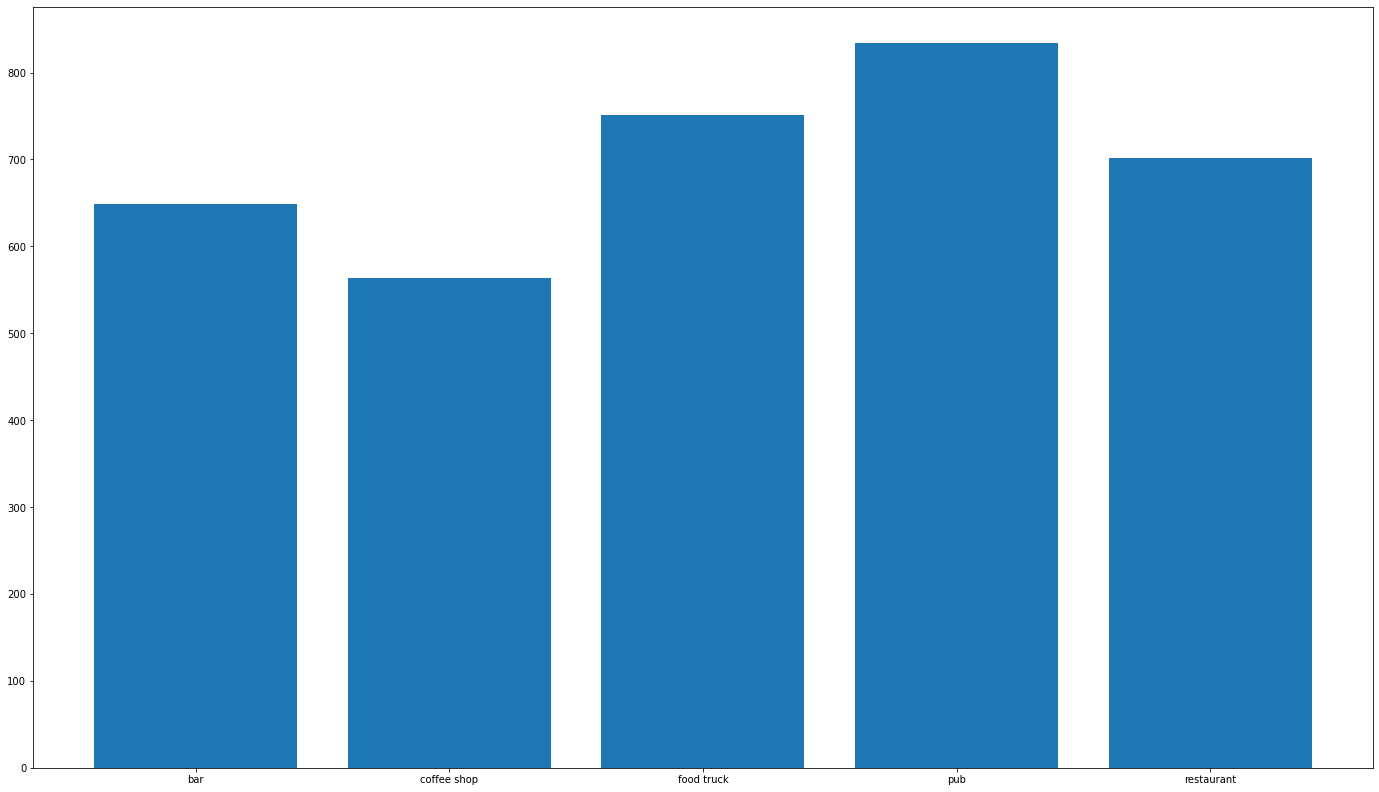

In [124]:
get_bar_plot_count(df_merge, 'merchant_category')

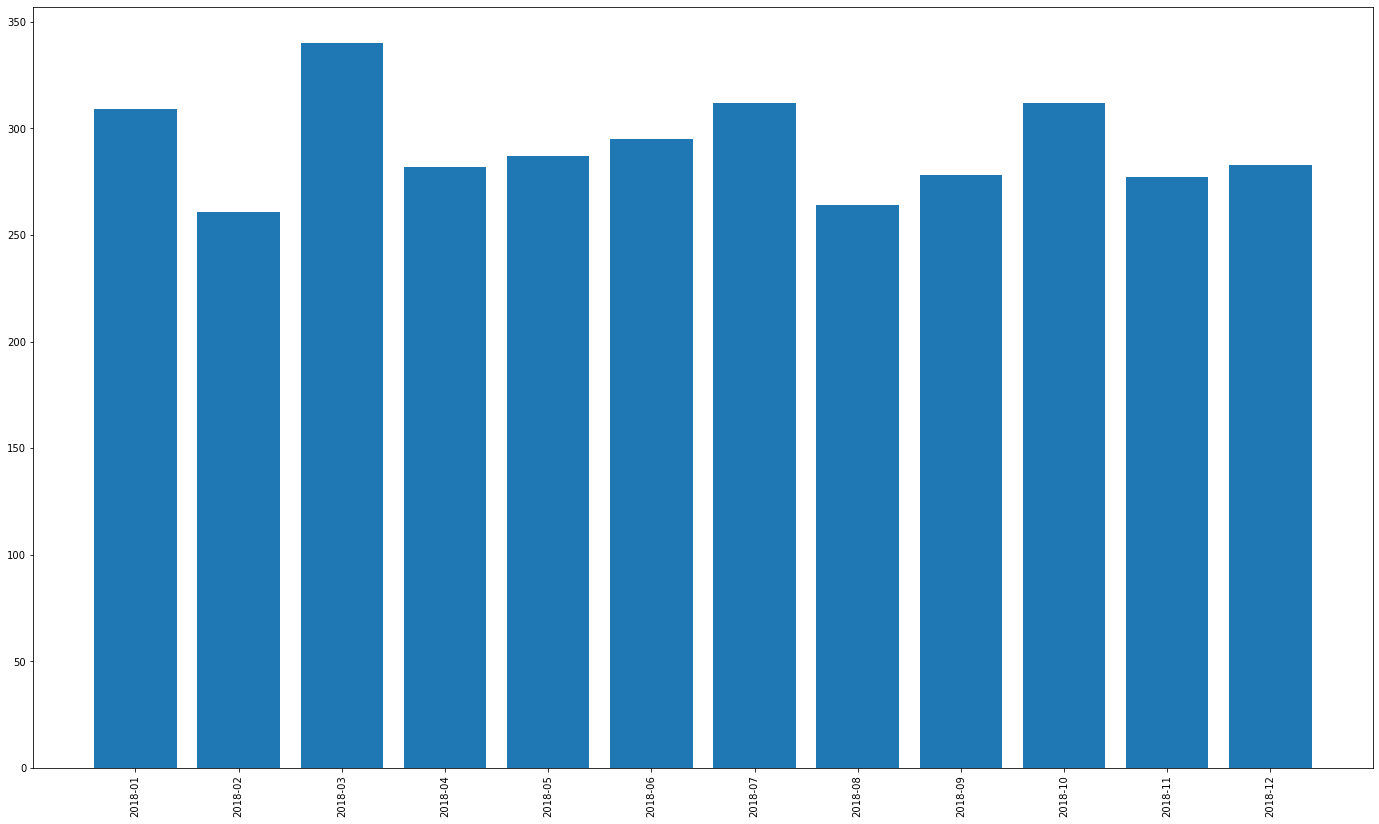

In [125]:
get_bar_plot_count(df_merge, 'date_month')

## Variables numéricas

### General

Como se puede observar claramente en la imagen de siguiente, la distribución del monto de las transacciones es claramente no-normal: la mayoría de los regitros se asocian a montos menores.

Esto permite ya de entrada comprender de que los montos altos no son tan recurrentes, lo cual permitiría que de forma sencilla algún método de Clustering identifique grupos según cercanía de valores altos o bajos.

<AxesSubplot:>

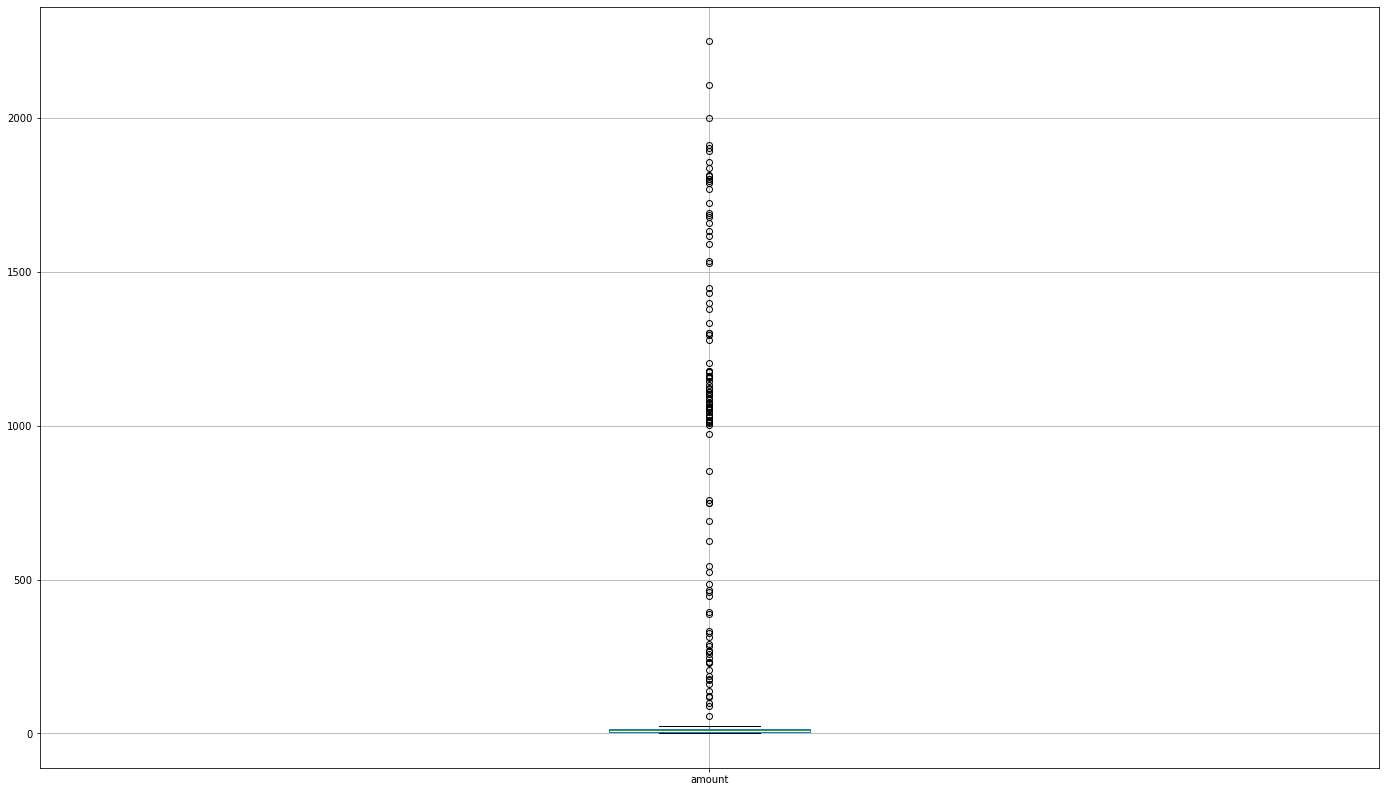

In [20]:
df_merge[['amount']].boxplot() 

### Por Clase

Siempre es conveniente, junto con ver la distribución general, también observar si existen diferencias significativas de la misma en relación a diferentes valores de una categoría de interés.

Dato que en este caso tenemos dos categorías principales, las siguientes imágenes muestra el resultado de su diagrama de caja para cada caso particular.

> Como se puede observar con claridad, no existe una diferencia notoria entre algún tipo de categoría y las demás. Esto permite concluir inicialmente que un tratamiento general de los datos es representativo en términos de distribución, en relación al conjunto de los datos.

<AxesSubplot:title={'center':'amount'}, xlabel='merchant_category'>

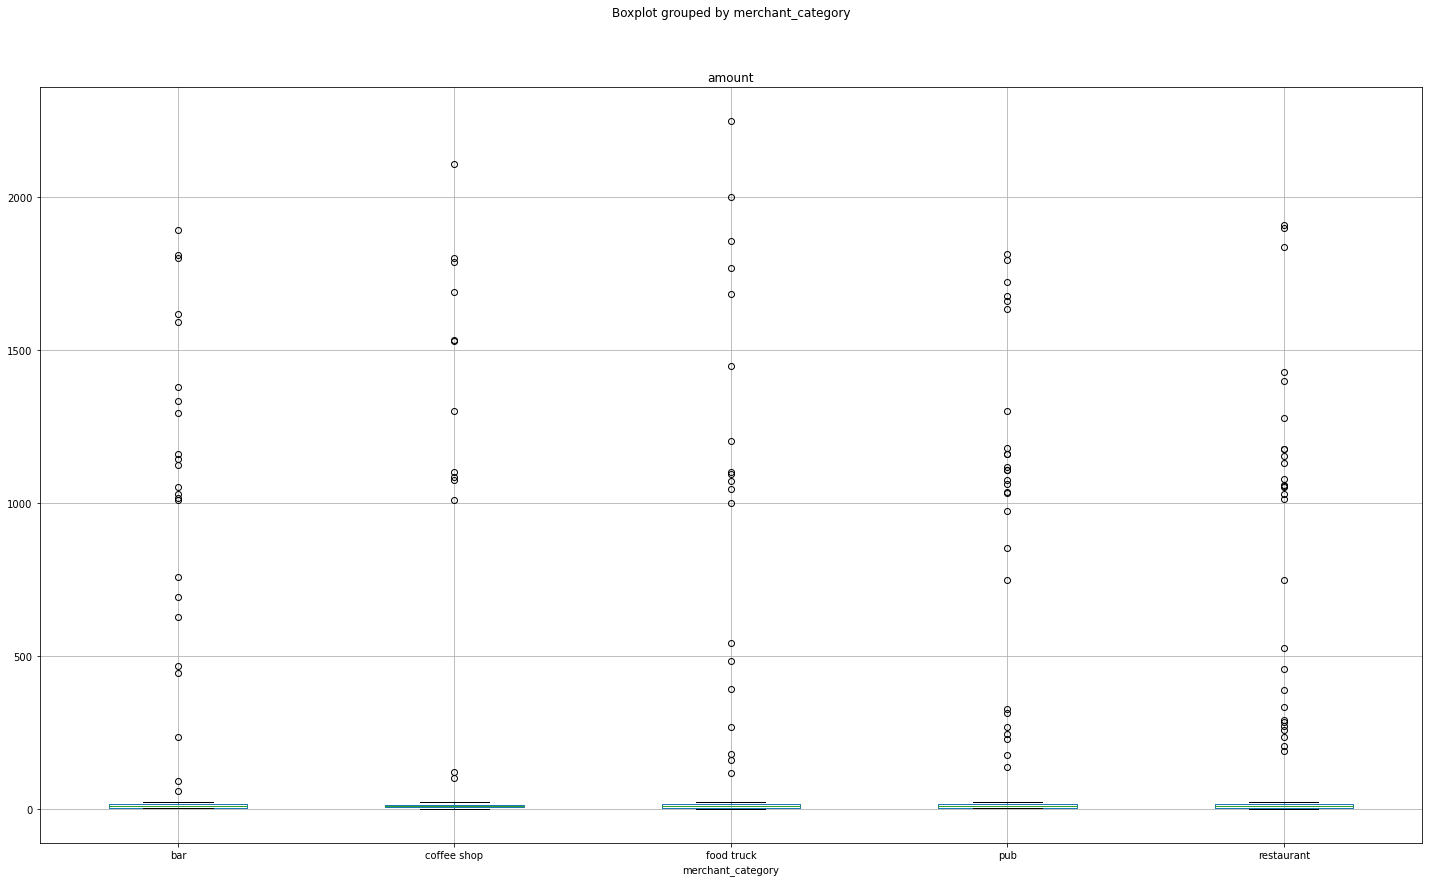

In [64]:
df_merge.boxplot('amount',by = 'merchant_category') 

La siguiente imagen muestra la distribución mediante diagramas de caja por hora del día. Al igual que en el caso anterior, vemos que no existe una diferencia visual importante entre la=os diferentes rangos horarios. 

> Nuevamente, esto permite descartar la necesidad de focalizar ciertos tipos de análisis con el fin de prevenir problemas de representación.

<AxesSubplot:title={'center':'amount'}, xlabel='hour'>

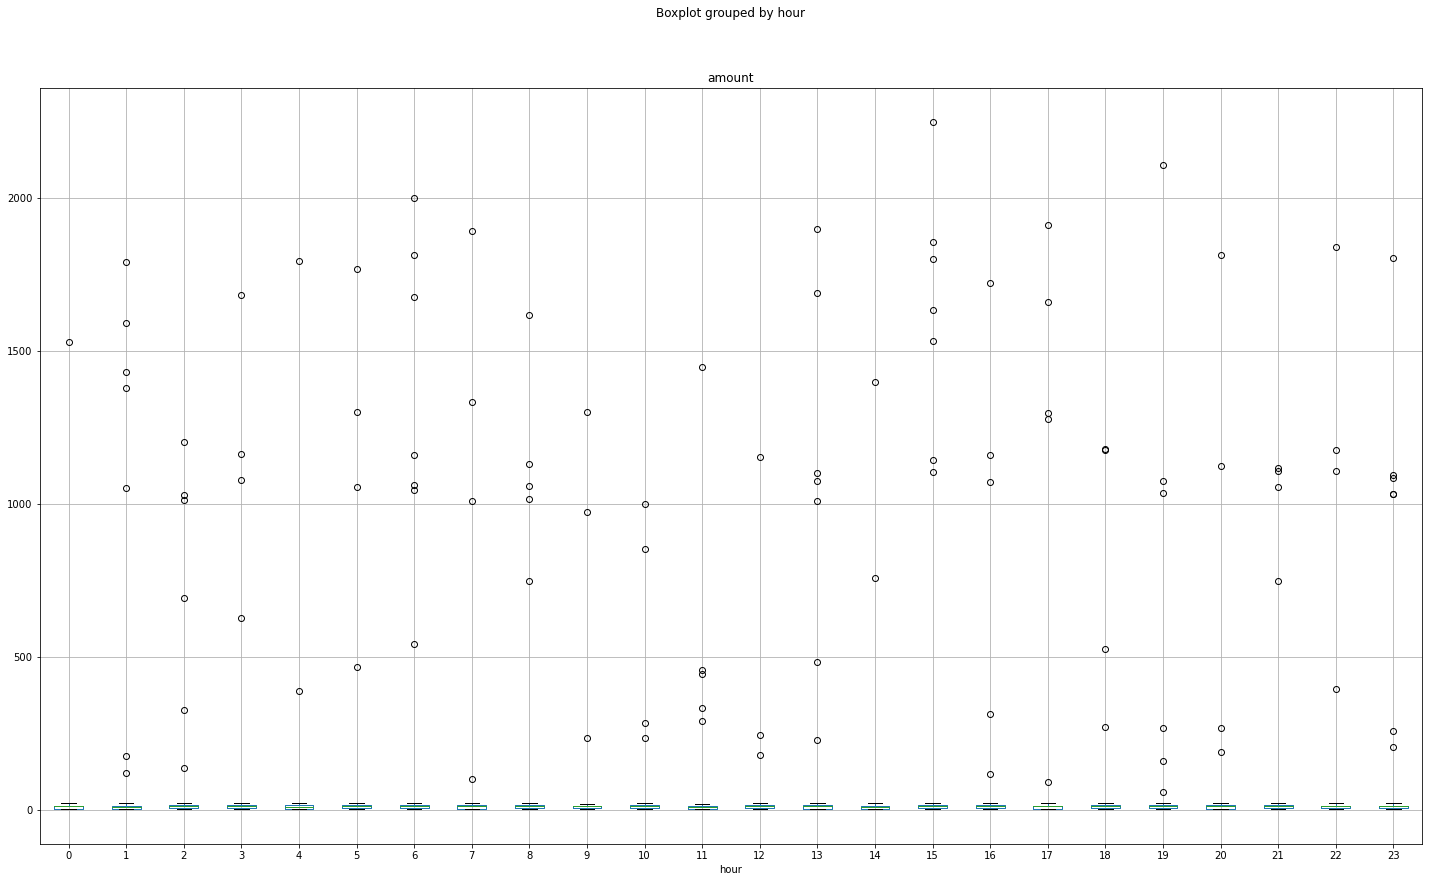

In [80]:
df_merge.boxplot('amount',by = 'hour') 

## Variables Temporales

Como no es sencillo de visualizar las transacciones de cada cliente, lo más sencillo es calcular la media diaria de los movimientos y ver su comportamiento. Esto debería indicar la relación anteriormente descrita entre valores bajos y altos de gastos.

> La siguiente gráfica reafirma lo planteado anteriormente. Vuelve a mostrar lo mismo pero de otra manera: la gran mayoría de los días la media es baja, salvo en aquellos casos puntuales donde las transacciones de alto valor alteran la posible uniformidad.

<AxesSubplot:xlabel='date_short'>

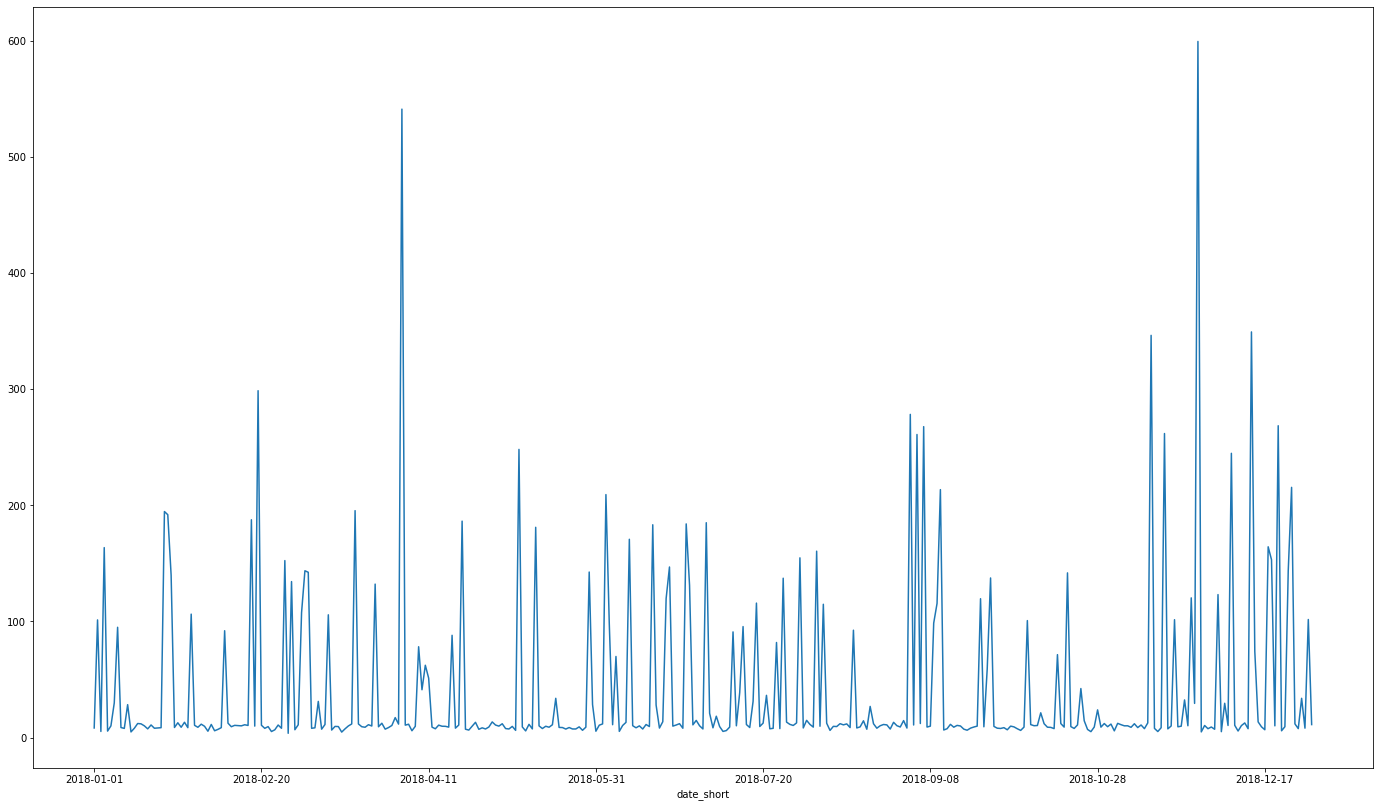

In [90]:
df_merge.groupby(['date_short'])['amount'].mean().plot(kind='line')

La siguiente gráfica muestra la deriva temporal de la cantidad total de registros diarios de transacciones.

Como se puede observar, no existe una tendencia clara no de subida ni de bajada. Además, se ve que los puntos más bajos tienden a coindicir con los puntos más altos de la media mostrada en la gráfica anterior, lo cual tiene sentido, ya que de esa forma un alto monto eleva el total de forma más sencilla.

Se podría entrar en el análisis estacional y estacionario propio de las series de tiempo, con su posible creación de modelos forecast para tratar de anticiparse a posibles alzas o bajas en cantidad de transferencias. Pero no es el propósito actual, por lo que sólo se menciona.

> En general, se puede afirmar que las osilaciones de la visualización reflejan una tendencia estable en el tiempo.

<AxesSubplot:>

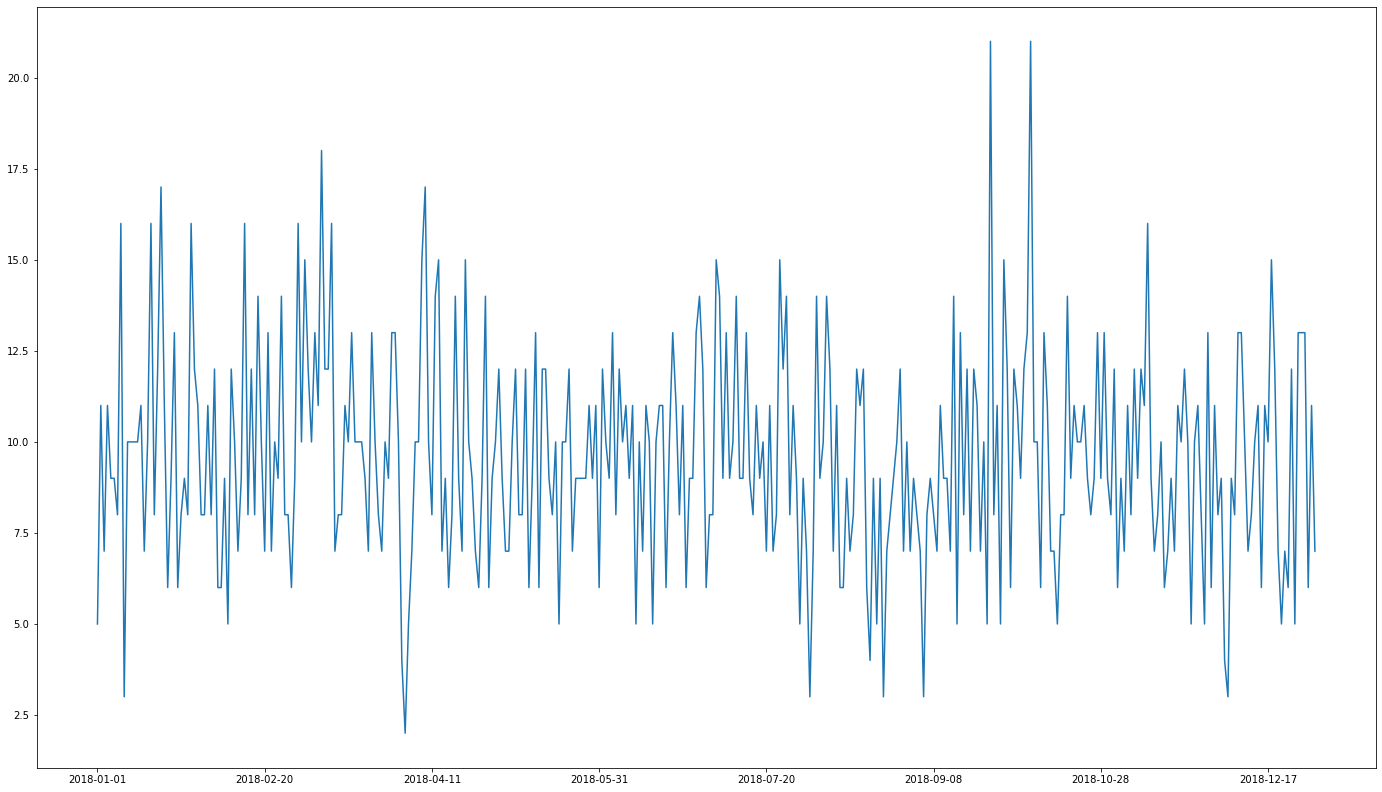

In [117]:
df_merge['date_short'].value_counts().sort_index().plot(kind='line')

# Exploración y Transformación de Datos

## Clusterización

La siguiente tabla muestra los resultados estadísticos asociados a las distribuciones de datos que fueron clasificados aplicando 4, 3 y 2 clusters con metodología Kmeans a los datos. Como se puede observar, se re afirma la idea anterios respecto de que el grupo más fuerte corresponde a la densidad de datos de menor monto asociado. Esto se comprueba ya que, com tan sólo 2 clusters ya se diferencian dos grupos con un valor de media muy diferente. Mientras que al subir la cantidad de clusters sólo se consigue ir dividiendo y segmentando aquellos valores de menor monto, quedando siempre un claster con casi 80 registros que podee una media mucho mayor a los demas.

> Esto permite inferir con seguridad que, al utilizar dos clusters obtendremos grupos disociados de forma coherente en relación a la diferencia visualizada en las gráficas anteriores.

In [30]:
NUM_CLUSTER: int = 4
df_info_4 = get_cluster_info(get_kmeans_clusters(df_merge, NUM_CLUSTER, True), NUM_CLUSTER)

NUM_CLUSTER: int = 3
df_info_3 = get_cluster_info(get_kmeans_clusters(df_merge, NUM_CLUSTER, True), NUM_CLUSTER)

NUM_CLUSTER: int = 2
df_info_2 = get_cluster_info(get_kmeans_clusters(df_merge, NUM_CLUSTER, True), NUM_CLUSTER)

display_side_by_side(
   [df_info_4, df_info_3,df_info_2],
   ['<h2>4 Clusters</h2>', '<h2>3 Clusters</h2>', '<h2>2 Clusters</h2>']
)

La siguiente imagen corresponde a un diagrama de caja aplicado a los valores altos asociados al cluster 0. Como se puede apreciar con facilidad, la distribución cambia mucho sólo en base a este tipo de segmentación: ahora los propios valores altos reparten sus valores de tal forma que no hay outliers tradicionales detectados. Esto permite inferir que es una correcta forma de diferenciarlos respecto de los demas, sin necesidad de establecer un punto de diferente arbitrario como monto mínimo.

<AxesSubplot:title={'center':'amount'}, xlabel='cluster'>

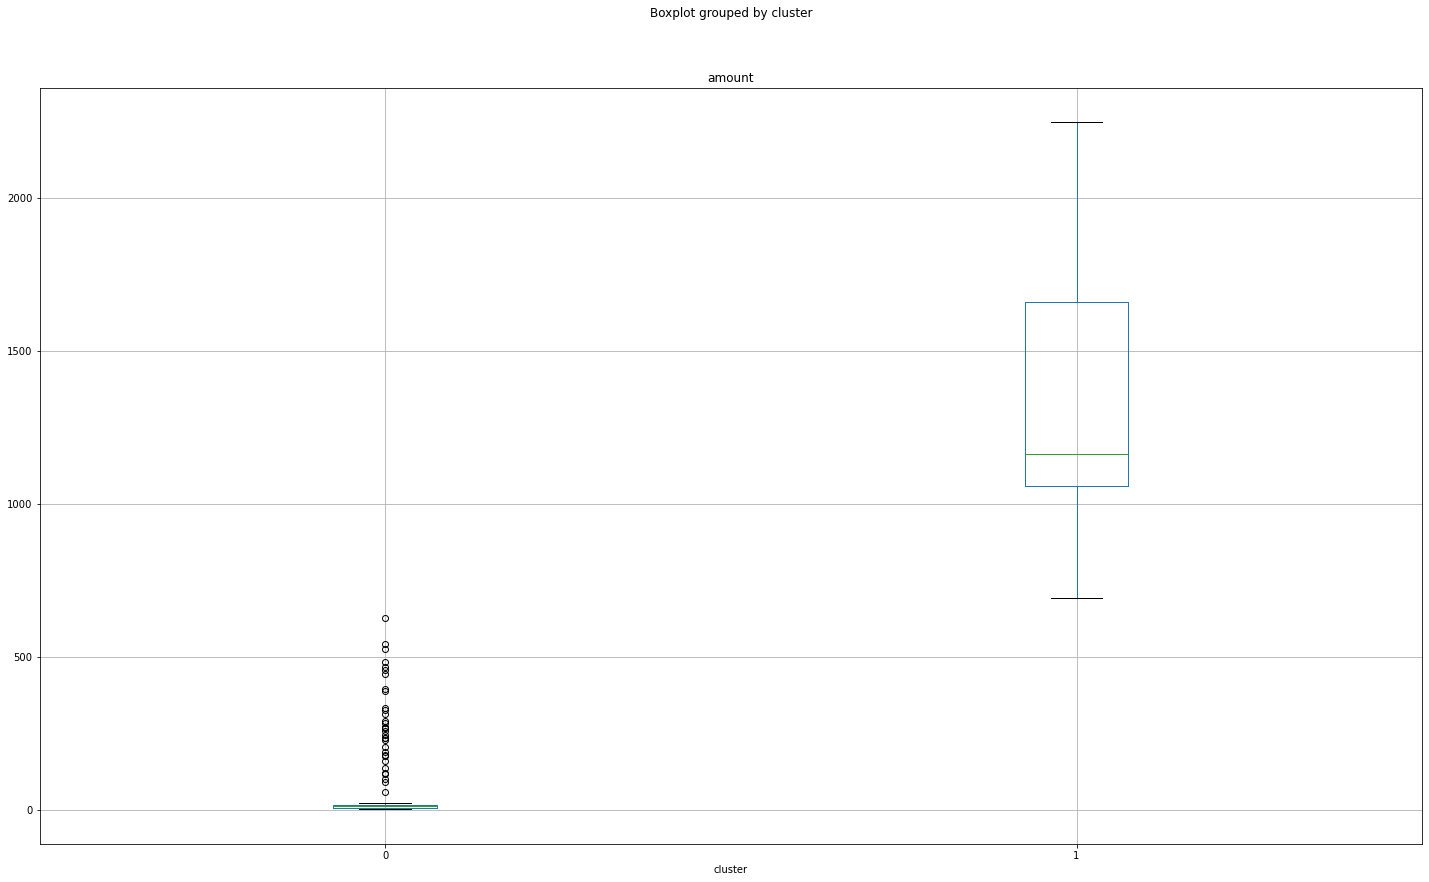

In [48]:
NUM_CLUSTER: int = 2
df_cluster = get_kmeans_clusters(df_merge, NUM_CLUSTER, True)
df_cluster.boxplot('amount',by = 'cluster') 

# Resolviendo las dudas

## Transacciones de Montos Altos

De acuerdo a lo señalado al inicio del informe, uno de los problemas se asocia a transacciones de montos alto realizadas a las primeras horas de la mañana. Dado que la hora d einicio y término es relativa al contexto de estudio, se definen como variables globales: la idea es que se pruebe con diferentes valores dependiendo el problema concreto. Por ahora se toma de referencia el período 6 a 8 A.M. Así, la siguiente tabla muestra el resultado de haber aplicado el filtro por cluster de altos valores a todas ls transacciones registradas dentro de dicha franja horaria.

> Todas estas transacciones deberían ser revisadas, ya que cumplen con las características señaladas de posible peligro de fraude.

In [27]:
NUM_CLUSTER: int = 2
START_HOUR: int = 6
END_HOUR: int = 8

df_morning = df_merge[(df_merge['hour'] >= START_HOUR) & (df_merge['hour'] <= END_HOUR)].reset_index(drop=True)
df_cluster = get_kmeans_clusters(df_morning, NUM_CLUSTER, True)
df_cluster[df_cluster['cluster'] == 0][MAIN_COLUMNS].reset_index(drop=True)

,id,date,amount,card
0,208,2018-12-14 08:51:41,748.00,501879657465
1,968,2018-09-26 08:48:40,1060.00,4761049645711555811
2,1341,2018-04-08 06:03:50,1063.00,4319653513507
3,1349,2018-07-14 06:09:18,1160.00,30078299053512
4,1368,2018-09-06 08:28:55,1017.00,4761049645711555811
5,1377,2018-05-13 06:31:20,1046.00,4319653513507
6,1442,2018-01-22 08:07:03,1131.00,5570600642865857
7,1620,2018-03-26 07:41:59,1009.00,30181963913340
8,2451,2018-03-05 08:26:08,1617.00,5570600642865857
9,2582,2018-06-22 06:16:50,1813.00,4319653513507


# Transacciones de Montos Bajos

El problema con las transacciones de montos bajos, tal y como se señaló al inicio, tiene que ver con un fenómeno de recurrencia. Dicho de otra forma, se realizan reiteradas transacciones de bajo monto y esto es lo que hace, por un lado que sea difícil enterarse, y por otro que finalmente el monto de fraude no sea menor.

> Dado de la definición de "reiterado" depende del contexto y del foco del problema, ahora se verá desde dos perspectivas: diario y por hora.

La tabla de la izquierda muestra todos los movimientos que cumplen con la siguiente condición: se realizaron el menos 6 transacciones menores a 3 dólares en menos de un día.

Se realiza el planteamiento mediante una función porque de esta manera se puede hacer flexible el análisis, pudiendo aumentar el monto a 5 y bajando la reiteración 5, por ejemplo. Esto permitiría que, dependiendo el caso concreto de estudio y el conocimiento actual del contexto, se busque seleccionar específicamente el conjunto de movimiento de interés.

Similar pero no igual al caso anterior, la tabla de la derecha muestra todos los movimientos que cumplen con la siguiente condición: se realizaron el menos 3 transacciones menores a 10 dólares en menos de una hora.

> Como ya se mencionó, esto es sólo un enfoque diferente del mismo problema de recurrencia: mucho más enfocado en lo inmediato, pero considerando menos repeticiones y un monto más alto.

In [59]:
display_side_by_side(
   [get_group_count(df_merge, 'date_short', 3, 7), get_group_count(df_merge, 'date_hour', 10, 3)],
   ['<h2>Transacciones Diarias</h2>', '<h2>Transacciones horarias</h2>']
)

,id,date,amount,card
0,857,2018-09-25 06:05:01,2.020000,3581345943543942
1,3449,2018-09-25 11:16:33,2.890000,4743204091443101696
2,829,2018-09-25 12:53:26,1.950000,6011987562414062
3,1951,2018-09-25 14:20:48,2.390000,180098539019105
4,820,2018-09-25 16:20:26,2.880000,3535651398328201
5,545,2018-09-25 20:23:14,2.790000,3517111172421930
6,772,2018-09-25 23:28:54,1.480000,501809222273
7,2380,2018-10-05 03:53:50,2.570000,6500236164848279
8,765,2018-10-05 07:41:47,2.490000,4027907156459098
9,3397,2018-10-05 08:27:56,1.360000,30078299053512


# Conclusiones

El objetivo de este informe era, mediante análisis exploratorio, identificar actividades fraudulentas por medio del análisis de datos.

Se presentó visualmente el comportamiento de la distribución de los datos de múltiples maneras. Se crearon clusters y se analizó tambien la distribución de los grupos resultantes. Finalmente, se propone una forma de identificación de grupos sospechosos de transacciones, siguiento los principios indicados al inicio del informe.

Este trabajo se propuso responder a preguntas importantes del negocio aún sin la necesidad de crear un modelo de machine learning supervisado. Si bien el acercamiento es diferente, se logra comprender, relacionar e identificar patrones importantes de los datos, lo cual permite un análisis más certero de sus características.